# Process raw data into aggregated counties based on health spending

In [ ]:
#this script should be run multiple times for each dataset. Later it should be made into a function so
#it is possible to call it easily for each dataset instead of just running it multiple times in the same kernel.

#import necessary libraries
from dask import dataframe as dpd
import pandas as pd
import time as time

#read in data in a non-lazy format. I must do this for every year I want to run my regression in (for my paper, 2016, 2017, 2018, 2019 and 2020)
t1 = time.time()
data = dpd.read_csv('/Users/arthurwu/Desktop/raw20192020contractsdata.csv',
                   usecols = ['primary_place_of_performance_county_name', 'federal_action_obligation', 'product_or_service_code',
                             'naics_code', 'primary_place_of_performance_state_name', 'action_date_fiscal_year'], error_bad_lines = False, engine = 'python', 
                    dtype={'naics_code': 'object', 'federal_action_obligation': 'object', 'product_or_service_code': 'object', 'action_date_fiscal_year': 'object'}, sep = ',')
data = data.persist()

#modify data so all datatypes and locations are proper
data['naics_code'] = dpd.to_numeric(data['naics_code'], errors = 'coerce')
data['federal_action_obligation'] = dpd.to_numeric(data['federal_action_obligation'], errors = 'coerce')
data['action_date_fiscal_year'] = dpd.to_numeric(data['action_date_fiscal_year'], errors = 'coerce')
data['location'] = data['primary_place_of_performance_county_name'].str.cat(data['primary_place_of_performance_state_name'], sep = ", ")
data = data.compute()

#import list of codes
codes = pd.read_csv('/Users/arthurwu/Desktop/codeskept.csv')
naicscodes = codes['naics_code_kept']
productcodes = codes['product_or_service_code_kept']
print('finished reading all data')

#filter data to only include contracts from that list of codes
finaldata = data.loc[(data['naics_code'].isin(naicscodes) | (data['product_or_service_code'].isin(productcodes)))]
print('finished sorting the data')

#aggregate the data
finaldata = data
finaldata = finaldata[['location', 'federal_action_obligation']]
finaldata = finaldata.groupby(['location']).sum()

#export the data
finaldata.to_csv('rawcontracts.csv')
t2 = time.time()
print('finished')
print(t2-t1)


# Merge the X-variables together

In [2]:
#load in all the data

import pandas as pd

data2016 = pd.read_csv('/Users/arthurwu/Desktop/actionobligation2016outliersincluded.csv')
data2016['Year'] = 2016
data2017 = pd.read_csv('/Users/arthurwu/Desktop/actionobligation2017outliersincluded.csv')
data2017['Year'] = 2017
data2018 = pd.read_csv('/Users/arthurwu/Desktop/actionobligation2018outliersincluded.csv')
data2018['Year'] = 2018
data2019 = pd.read_csv('/Users/arthurwu/Desktop/actionobligation2019outliersincluded.csv')
data2019['Year'] = 2019

deaths = pd.read_excel('/Users/arthurwu/Desktop/rawdeaths.xlsx')
covars = pd.read_csv('/Users/arthurwu/Desktop/countycomplete.csv')

In [3]:
#create dictionaries because I might have to convert state names to abbreviations

abbrevmapper = {'alabama':'AL', 'alaska':'AK', 'arizona':'AZ', 'arkansas':'AR', 'california':'CA',
               'colorado':'CO', 'connecticut':'CT', 'delaware':'DE', 'district of columbia':'DC',
               'florida':'FL', 'georgia':'GA', 'hawaii':'HI', 'idaho':'ID', 'illinois':'IL', 
               'indiana':'IN', 'iowa':'IA', 'kansas':'KS', 'kentucky':'KY', 'louisiana':'LA', 'maine':'ME',
               'maryland':'MD', 'massachusetts':'MA', 'michigan':'MI', 'minnesota':'MN', 'mississippi':'MS',
               'missouri':'MO', 'montana':'MT', 'nebraska':'NE', 'nevada':'NV', 'new hampshire':'NH', 
               'new jersey':'NJ', 'new mexico':'NM', 'new york':'NY', 'north carolina':'NC', 'north dakota':'ND',
               'ohio':'OH', 'oklahoma':'OK', 'oregon':'OR', 'pennsylvania':'PA', 'rhode island':'RI',
               'south carolina':'SC', 'south dakota':'SD', 'tennessee':'TN', 'texas':'TX', 'utah':'UT',
               'vermont':'VT', 'virginia':'VA', 'virgin islands':'VI', 'washington':'WA', 'west virginia':'WV',
               'wisconsin':'WI', 'wyoming':'WY'}

newmapper = {v: k for k, v in abbrevmapper.items()}

In [4]:
#create a new, in-place column showing an entry's percentile.

from scipy import stats

def percentiles(df):
    df['percentile'] = 0
    for i in range(len(df['percentile'])):
        df.at[i, 'percentile'] = stats.percentileofscore(df['federal_action_obligation'], df.iloc[i, df.columns.get_loc('federal_action_obligation')])
    

In [5]:
#change state names into abbreviations, which will allow deaths data to be merged

def prepareForMerge(data, countylabel):
    for i in range(len(data['state'])):
        element = data.iloc[i, data.columns.get_loc('state')]
        element = element.lower()
        data.iloc[i, data.columns.get_loc('state')] = abbrevmapper[element]
    
    data[countylabel] = data[countylabel].str.split(', ').str[0]
    data[countylabel] = data[countylabel] + ', ' + data['state']
    data[countylabel] = data[countylabel].str.lower()

In [6]:
#modify covariates to allow merger
covars['location'] = covars['name'].str[:-7] + ', ' + covars['state']
covars['location'] = covars['location'].str.upper()

In [7]:
#merge covariates

data2016 = data2016.merge(covars, on='location')
data2017 = data2017.merge(covars, on='location')
data2018 = data2018.merge(covars, on='location')
data2019 = data2019.merge(covars, on='location')

In [8]:
#process rest of xvars for merging with deaths
data2016 = data2016.rename(columns = {'location':'County'})
data2017 = data2017.rename(columns = {'location':'County.1'})
data2018 = data2018.rename(columns = {'location':'County.2'})
data2019 = data2019.rename(columns = {'location':'County.3'})

# for i in range(len(data2016['state'])):
#     element = data2016.iloc[i, data2016.columns.get_loc('state')]
#     element = element.lower()
#     print(element)
#     data2016.iloc[i, data2016.columns.get_loc('state')] = abbrevmapper[element]
    
# data2016['County'] = data2016['County'].str.split(', ').str[0]
# data2016['County'] = data2016['County'] + ', ' + data2016['state']
# data2016['County'] = data2016['County'].str.lower()

prepareForMerge(data2016, 'County')
prepareForMerge(data2017, 'County.1')
prepareForMerge(data2018, 'County.2')
prepareForMerge(data2019, 'County.3')

In [ ]:
#process deaths for merging with rest of xvars
deaths2016 = deaths[['County', 'Deaths', 'Population']]
deaths2016['County'] = deaths2016['County'].str[:-11] + deaths2016['County'].str[-4:]
deaths2016['County'] = deaths2016['County'].str.lower()

deaths2017 = deaths[['County.1', 'Deaths.1', 'Population.1']]
deaths2017['County.1'] = deaths2017['County.1'].str[:-11] + deaths2017['County.1'].str[-4:]
deaths2017['County.1'] = deaths2017['County.1'].str.lower()

deaths2018 = deaths[['County.2', 'Deaths.2', 'Population.2']]
deaths2018['County.2'] = deaths2018['County.2'].str[:-11] + deaths2018['County.2'].str[-4:]
deaths2018['County.2'] = deaths2018['County.2'].str.lower()

deaths2019 = deaths[['County.3', 'Deaths.3', 'Population.3']]
deaths2019['County.3'] = deaths2019['County.3'].str[:-11] + deaths2019['County.3'].str[-4:]
deaths2019['County.3'] = deaths2019['County.3'].str.lower()

In [10]:
#perform inner merge on the counties

data2016 = data2016.merge(deaths2016, on='County')
data2017 = data2017.merge(deaths2017, on='County.1')
data2018 = data2018.merge(deaths2018, on='County.2')
data2019 = data2019.merge(deaths2019, on='County.3')

In [11]:
#create per capita and deathratio metrics
data2016['deathratio'] = data2016['Deaths']/data2016['Population']
data2017['deathratio'] = data2017['Deaths.1']/data2017['Population.1']
data2018['deathratio'] = data2018['Deaths.2']/data2018['Population.2']
data2019['deathratio'] = data2019['Deaths.3']/data2019['Population.3']

data2016['perCapitaSpending'] = data2016['federal_action_obligation']/data2016['pop2016']
data2017['perCapitaSpending'] = data2017['federal_action_obligation']/data2017['pop2017']
data2018['perCapitaSpending'] = data2018['federal_action_obligation']/data2018['pop2017']
data2019['perCapitaSpending'] = data2019['federal_action_obligation']/data2019['pop2017']

In [12]:
#rename data to prepare for concatenation
data2017 = data2017.rename(columns = {'County.1':'County', 'Deaths.1':'Deaths', 'Population.1':'Population'})
data2018 = data2018.rename(columns = {'County.2':'County', 'Deaths.2':'Deaths', 'Population.2':'Population'})
data2019 = data2019.rename(columns = {'County.3':'County', 'Deaths.3':'Deaths', 'Population.3':'Population'})

In [13]:
#for each year, truncate the data and pick specific covariates to use (not all years have all covariates available)
percentiles(data2016)
data2016 = data2016.loc[(data2016['percentile'] > 1) & (data2016['percentile'] < 99)]
data2016 = data2016[['County', 'Year', 'perCapitaSpending', 'density_2010', 'uninsured_2017', 'avg_family_size_2019', 'unemployment_rate_2016', 'per_capita_income_2017', 'bachelors_2016', 'white_not_hispanic_2017', 'age_over_65_2017', 'poverty_2016', 'fips', 'pop2016']]

percentiles(data2017)
data2017 = data2017.loc[(data2017['percentile'] > 1) & (data2017['percentile'] < 99)]
data2017 = data2017[['County', 'Year', 'perCapitaSpending', 'density_2010', 'uninsured_2017', 'avg_family_size_2019', 'white_not_hispanic_2017', 'unemployment_rate_2017', 'per_capita_income_2017', 'bachelors_2017', 'age_over_65_2017', 'poverty_2017', 'fips', 'pop2017']]
                     
percentiles(data2018)
data2018 = data2018.loc[(data2018['percentile'] > 1) & (data2018['percentile'] < 99)]
data2018 = data2018[['County', 'Year', 'perCapitaSpending', 'density_2010', 'uninsured_2017', 'avg_family_size_2019', 'white_not_hispanic_2017', 'unemployment_rate_2017', 'per_capita_income_2017', 'bachelors_2017', 'age_over_65_2017', 'poverty_2017', 'fips', 'pop2017']]

percentiles(data2019)
data2019 = data2019.loc[(data2019['percentile'] > 1) & (data2019['percentile'] < 99)]
data2019 = data2019[['County', 'Year', 'perCapitaSpending', 'density_2010', 'avg_family_size_2019', 'unemployment_rate_2019', 'per_capita_income_2019', 'bachelors_2019', 'white_not_hispanic_2019', 'age_over_65_2019', 'uninsured_2019', 'poverty_2019', 'fips', 'pop2017']]


In [14]:
#process all finances data

import pandas as pd

def processFinances(path):
    financedata = pd.read_csv(path)
    financedata.columns = ['Original']
    financedata['ID'] = ''
    financedata['AmountYear'] = ''

    financedata['ID'] = financedata['Original'].str.split(' ').str[0]
    financedata['AmountYear'] = financedata['Original'].str.split(' ').str[-1]

    financedata = financedata.drop(columns = ['Original'])
    financedata['ItemCode'] = financedata['ID'].str[-3] + financedata['ID'].str[-2] + financedata['ID'].str[-1]
    financedata['fipscode'] = financedata['ID'].str[0:2] + financedata['ID'].str[3:6]
    financedata['value'] = financedata['AmountYear'].str[:-5]
    financedata['value'] = pd.to_numeric(financedata['value'])

    #need to filter out to make sure only health funding on county level appears

    financedata = financedata.loc[(financedata['ItemCode'] == 'A36') | (financedata['ItemCode'] == 'B42') | (financedata['ItemCode'] == 'C42') | (financedata['ItemCode'] == 'D42') | (financedata['ItemCode'] == 'E32') | (financedata['ItemCode'] == 'F32') | (financedata['ItemCode'] == 'G32') | (financedata['ItemCode'] == 'L32') | (financedata['ItemCode'] == 'M32')]
    financedata = financedata.drop(columns = ['ID', 'AmountYear', 'ItemCode'])

    financedata = financedata.groupby(['fipscode']).sum()
    financedata = financedata.reset_index()
    financedata.columns = [['fips', 'financevalue']]
    return financedata

finances2016 = processFinances('/Users/arthurwu/Desktop/2016finances.txt')
finances2017 = processFinances('/Users/arthurwu/Desktop/2017finances.txt')
finances2018 = processFinances('/Users/arthurwu/Desktop/2018finances.txt')
finances2019 = processFinances('/Users/arthurwu/Desktop/2019finances.txt')

# merge all finances data

data2016 = data2016.merge(finances2016, on='fips')
data2017 = data2017.merge(finances2117, on='fips')
data2018 = data2018.merge(finances2018, on='fips')
data2019 = data2019.merge(finances2019, on='fips')

#add new per capita column
data2016['financevalue'] = data2016['financevalue']/data2016['pop2016']
data2017['financevalue'] = data2017['financevalue']/data2017['pop2017']
data2018['financevalue'] = data2018['financevalue']/data2018['pop2017']
data2019['financevalue'] = data2019['financevalue']/data2019['pop2017']


In [16]:
#output all the data

data2016.to_csv('panel16.csv')
data2017.to_csv('panel17.csv')
data2018.to_csv('panel18.csv')
data2019.to_csv('panel19.csv')

<AxesSubplot:xlabel='financevalue', ylabel='Count'>

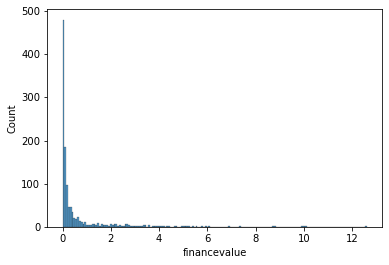

In [29]:
#distribution of grant funding per capita

import seaborn as sns

sns.histplot(data2019['financevalue'])